# Dataset A Thaliana

## Übersicht

Das selbe Notebook wie "athaliana_outliers"

Die Outlier die im Laufe des Notebooks gefunden wurden am Anfang schon entfernt werden, und Clustering wird durchgeführt.


## Imports

In [3]:
import os
import sys

sys.path.append('../../src')
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

from yellowbrick.features import ParallelCoordinates
from yellowbrick.features import Rank1D, Rank2D

import pandas as pd
import numpy as np
import seaborn as sns

from dataset.transporter_dataset import create_dataset
from dataset.cluster_fasta import cd_hit
from features.labels import fasta_to_labels
from features.compositions import calculate_composition_feature
from features.pssm import calculate_pssm_feature
from features.coexp import calculate_coexp_feature
from models.eval import nested_crossval
from visualization.feature_plots import create_plot

## Globals

In [4]:
LOG_FILE = "../../logs/athaliana_amino_sugar.log"
N_THREADS = 16
IDENTITY_THRESHOLD=70

## 1. Creating the dataset

### Filtering (Keywords, organism, outliers)

In [5]:
# Delete previous log
if os.path.exists(LOG_FILE):
    with open(LOG_FILE, "w"):
        pass

create_dataset(
    keywords_substrate_filter=["Amino-acid transport", "Sugar transport"],
    keywords_component_filter=["Membrane"],
    keywords_transport_filter=["Transport"],
    input_file="../../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="remove",
    outliers=["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"],
    verbose=True,
    tax_ids_filter=[3702],
    output_tsv="../../data/datasets/athaliana_amino_sugar.tsv",
    output_fasta="../../data/datasets/athaliana_amino_sugar.fasta",
    output_log=LOG_FILE,
)

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
Q9SFG0,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP6 At3g05960 F2O10.8,Sugar transport protein 6 (Hexose transporter 6),2.A.1.1.56,3702,MAVVVSNANAPAFEAKMTVYVFICVMIAAVGGLIFGYDIGISGGVS...
Q9ZVK6,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,SUC8 At2g14670 T6B13.9,Sucrose transport protein SUC8 (Sucrose permea...,NaN,3702,MSDLQAKNDVVAVDRQSSSSLADLDGPSPLRKMISVASIAAGIQFG...
Q84WN3,Sugar transport,Membrane;Transmembrane,Transport,SWEET17 At4g15920 dl4000c FCAALL.237,Bidirectional sugar transporter SWEET17 (AtSWE...,NaN,3702,MAEASFYIGVIGNVISVLVFLSPVETFWKIVKRRSTEEYKSLPYIC...
O04249,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,STP7 At4g02050 AGAA.1 T10M13.6,Sugar transport protein 7 (Hexose transporter 7),NaN,3702,MAGGSFGPTGVAKERAEQYQGKVTSYVIIACLVAAIGGSIFGYDIG...
Q56ZZ7,Sugar transport,Membrane;Plastid inner membrane;Transmembrane,Transport,At5g16150 T21H19.70,Plastidic glucose transporter 4 (AtpGlcT),2.A.1.1.102,3702,MQSSTYAVKGNAAFAFQRRTFSSDRSTTSTGIRFAGYKSLATTGPL...
...,...,...,...,...,...,...,...,...
Q94EI9,Sugar transport,Membrane;Transmembrane,Transport,At3g14410 MLN21.19,Probable sugar phosphate/phosphate translocato...,NaN,3702,MADRSKGFMRAEFVTYAYILLYIALSSGQIFFNKWVLSSKEINFPY...
Q8L6Z8,Sugar transport,Membrane;Transmembrane,Transport,At3g03090 T17B22.22,D-xylose-proton symporter-like 1,2.A.1.1.45,3702,MGFDPENQSISSVGQVVGDSSSGGITAEKEPLLKENHSPENYSVLA...
Q9FDZ5,Sugar transport,Membrane;Transmembrane,Antiport;Transport,URGT6 At1g34020 F12G12.16 T15K4.8,UDP-rhamnose/UDP-galactose transporter 6 (UDP-...,NaN,3702,MAPVSKADKKAAVDAAAWMFNVVTSVGIIIVNKALMATYGYSFATT...


### Creating a table of GO/Keyword annotations

TODO: Wenn nötig dann Keywords und GO terms zu Tabelle hinzufügen

In [6]:
df_annotations = pd.read_table("../../data/datasets/athaliana_amino_sugar.tsv", index_col=0)
df_annotations.head()

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
Q9SFG0,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP6 At3g05960 F2O10.8,Sugar transport protein 6 (Hexose transporter 6),2.A.1.1.56,3702,MAVVVSNANAPAFEAKMTVYVFICVMIAAVGGLIFGYDIGISGGVS...
Q9ZVK6,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,SUC8 At2g14670 T6B13.9,Sucrose transport protein SUC8 (Sucrose permea...,NaN,3702,MSDLQAKNDVVAVDRQSSSSLADLDGPSPLRKMISVASIAAGIQFG...
Q84WN3,Sugar transport,Membrane;Transmembrane,Transport,SWEET17 At4g15920 dl4000c FCAALL.237,Bidirectional sugar transporter SWEET17 (AtSWE...,NaN,3702,MAEASFYIGVIGNVISVLVFLSPVETFWKIVKRRSTEEYKSLPYIC...
O04249,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,STP7 At4g02050 AGAA.1 T10M13.6,Sugar transport protein 7 (Hexose transporter 7),NaN,3702,MAGGSFGPTGVAKERAEQYQGKVTSYVIIACLVAAIGGSIFGYDIG...
Q56ZZ7,Sugar transport,Membrane;Plastid inner membrane;Transmembrane,Transport,At5g16150 T21H19.70,Plastidic glucose transporter 4 (AtpGlcT),2.A.1.1.102,3702,MQSSTYAVKGNAAFAFQRRTFSSDRSTTSTGIRFAGYKSLATTGPL...


### Clustering


In [7]:
cd_hit(
    executable_location="cd-hit",
    input_fasta=f"../../data/datasets/athaliana_amino_sugar.fasta",
    output_fasta=f"../../data/datasets/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}.fasta",
    log_file=LOG_FILE,
    identity_threshold=IDENTITY_THRESHOLD,
    n_threads=N_THREADS,
    memory=4096,
    verbose=True,
)

## 2. Feature generation

### 2.1 Labels

In [8]:
fasta_to_labels(
    input_fasta=f"../../data/datasets/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}.fasta",
    output_tsv=f"../../data/features/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}_labels.tsv",
)
pd.read_table(
    f"../../data/features/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}_labels.tsv",
    index_col=0,
).labels.value_counts()

Sugar transport         84
Amino-acid transport    33
Name: labels, dtype: int64

### 2.2 AAC

In [9]:
for composition_type in ["aac"]:
    calculate_composition_feature(
        input_fasta=f"../../data/datasets/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}.fasta",
        output_tsv="../../data/features/athaliana_amino_sugar_cluster{}_{}.tsv".format(
            IDENTITY_THRESHOLD, composition_type
        ),
        feature_type=composition_type,
    )

## 3. Feature visualization (AAC, Clustering 70, keine Outlier)

### 3.1 Clustermap

Die Clustermap zeigt, dass die 20 Features sich eindeutig in zwei Cluster einteilen lassen, eins mit häufigen Aminosäuren und eins mit weniger häufigen. 

Features:

- Bei den häufigen Aminosäuren sticht vorallem Leucin hervor
- Bei den weniger häüfigen gibt es ein Unter-cluster von drei AS mit sehr deutliche geringerer Frequenz.
- Um festzustellen, ob dieses Muster typisch für Transporter ist, oder für dieses Substrate, müsste man den selben Plot für andere Datensätze erstellen.

TODO: Ist dieses Muster typisch für Transporter? Vergleich mit Background set.

Samples:

- Die Substrate sind durch HClustering nicht eindeutig zuweißbar.
- Könnte auf komplexeres Modell hinweisen, dass 3 oder mehr Dimensionen braucht

{'Sugar transport': 'red', 'Amino-acid transport': 'green'}


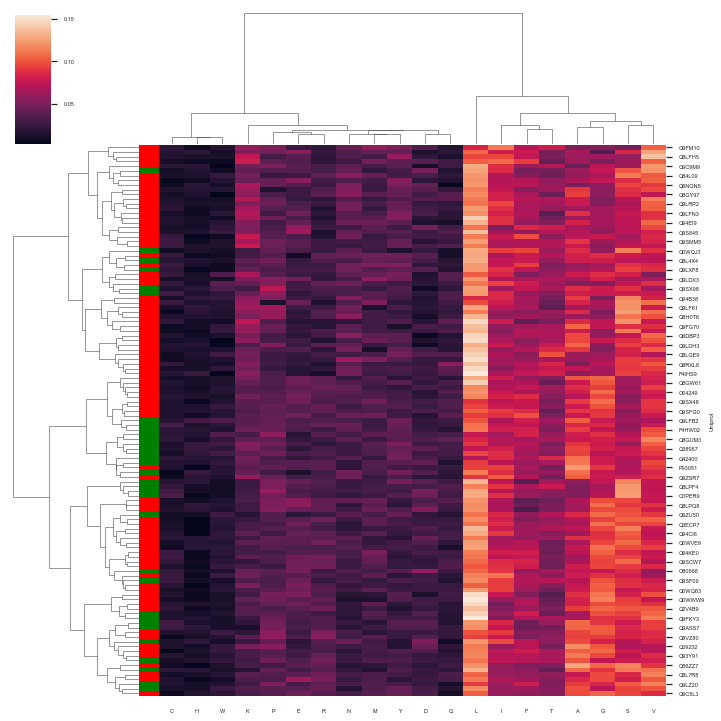

In [ ]:
create_plot(
    input_features=f"../data/features/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}_aac.tsv",
    input_labels=f"../data/features/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}_labels.tsv",
    log_file=LOG_FILE,
    type="sample",
    verbose=True,
)
plt.savefig("plots/athaliana_sugar_amino_cluster70_aac_clustermap_samples_features.png", dpi=300)

### 3.2 Korrelation der Proteine

Dies ist eine Heatmap mit Ward-clustering von den Proteinen. 

- Der Datensatz lässt sich in zwei Teile clustern, allerdings entspricht dies nicht unbedingt den Substraten. 
- Es gibt vier Zuckertransporter, die eine niedrige Korrelation haben zum rest des Datensatzes. Hierbei handelt es sich um Proteine aus der SWEET familie (5, 8, 10, 15). Die durchschnittliche paarweise Korrelation ist 0.69-0.79, außerdem handelt es sich um Porter (2A)

{'Sugar transport': 'red', 'Amino-acid transport': 'green'}


/home/ad/subpred/venv/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


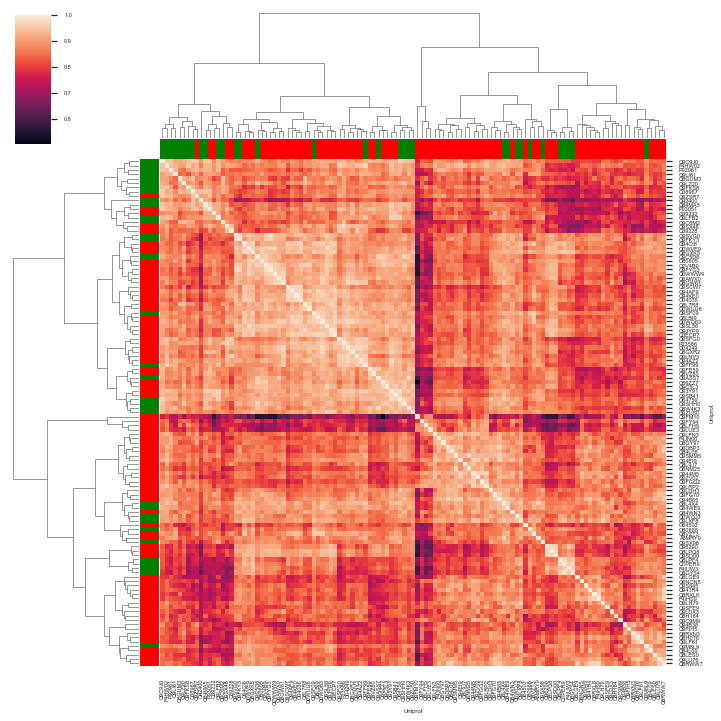

In [ ]:
create_plot(
    input_features=f"../data/features/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}_aac.tsv",
    input_labels=f"../data/features/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}_labels.tsv",
    log_file=LOG_FILE,
    type="corr_samples",
    verbose=True
)
plt.savefig("plots/athaliana_sugar_amino_cluster70_aac_clustermap_samples_samples.png", dpi=300)

### Wie ist die Verteilung der TCDB Klassen?

Gelb: Hat eine TCDB Klasse (hier ausschließlich Familie 2.A)

Blau: Hat keine TCDB Klasse. 

- Oft sieht man, dass ein Protein, was nicht in der TCDB ist, einem TCDB Protein sehr ähnlich ist, und sich im selben Cluster befindet. Man kann also durch clustering nicht klar unterscheiden zwischen TCDB und nicht-TCDB.

/home/ad/subpred/venv/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


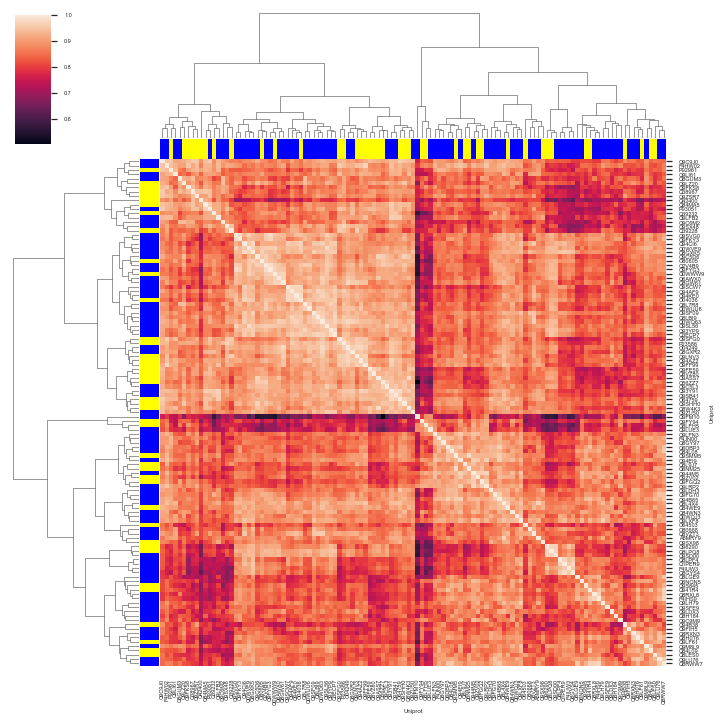

In [ ]:
df_aac = pd.read_table(
    f"../data/features/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}_aac.tsv",
    index_col=0,
)
df_labels = pd.read_table(
    f"../data/features/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}_labels.tsv",
    index_col=0,
)
label_colors = (
    [
        "blue" if not_in_tcdb else "yellow"
        for not_in_tcdb in df_annotations.loc[df_aac.index, "tcdb_id"].isnull()
    ],
)
sns.set(font_scale=0.5)

sns.clustermap(
    data=df_aac.transpose().corr(),
    xticklabels=df_labels.index,
    yticklabels=df_labels.index,
    col_colors=label_colors,
    row_colors=label_colors,
    method="ward",
)

sns.set(font_scale=1)
plt.savefig("plots/athaliana_sugar_amino_cluster70_aac_clustermap_tcdb_members_yellow.png", dpi=300)

### 3.3 Korrelation der Features

- Nur wenige Features haben eine hohe Korrelation zueinander im gesamten Datensatz
- Das ändert sich etwas, wenn man Features nur von einer Transporter-Klasse anguckt (Plots 2 und 3)
- Schlussfolgerung: 
    - PCA mit wenigen Komponenten verliert viel zu Information.

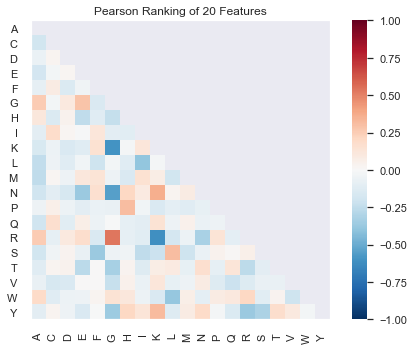

<AxesSubplot:title={'center':'Pearson Ranking of 20 Features'}>

In [ ]:
df_aac = pd.read_table(
    f"../data/features/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}_aac.tsv", index_col=0
)
df_labels = pd.read_table(
    f"../data/features/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}_labels.tsv", index_col=0
)
r2d = Rank2D(algorithm="pearson")
r2d.fit_transform(df_aac, df_labels.labels)
plt.savefig("plots/athaliana_sugar_amino_cluster70_aac_pearson_ranking_all.png", dpi=300)
r2d.show()

#### Nur AA transporter

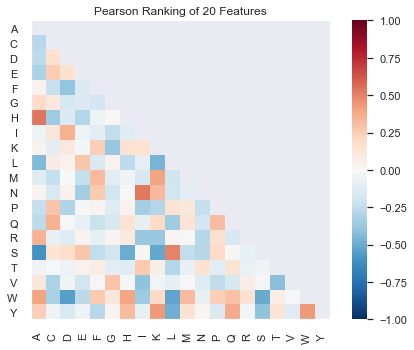

<AxesSubplot:title={'center':'Pearson Ranking of 20 Features'}>

In [ ]:
mask_amino = df_labels.labels == "Amino-acid transport"
r2d = Rank2D(algorithm='pearson')
r2d.fit_transform(df_aac.loc[mask_amino], df_labels.loc[mask_amino].labels)
plt.savefig("plots/athaliana_sugar_amino_cluster70_aac_pearson_ranking_aa.png", dpi=300)
r2d.show()

#### Nur Sugar transporter

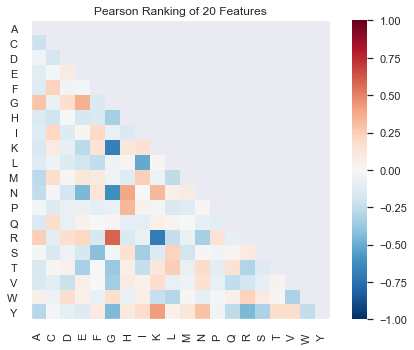

<AxesSubplot:title={'center':'Pearson Ranking of 20 Features'}>

In [ ]:
mask_sugar = df_labels.labels == "Sugar transport"
r2d = Rank2D(algorithm='pearson')
r2d.fit_transform(df_aac.loc[mask_sugar], df_labels.loc[mask_sugar].labels)
plt.savefig("plots/athaliana_sugar_amino_cluster70_aac_pearson_ranking_sugar.png", dpi=300)
r2d.show()

### 3.4 Folgen die AAC Features einer Normalverteilung?

Nach Entfernen der Outlier folgen alle Features einer Normalverteilung.

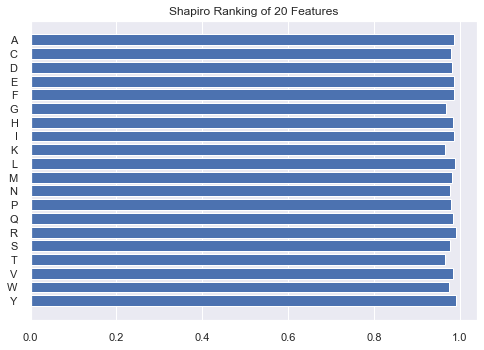

<AxesSubplot:title={'center':'Shapiro Ranking of 20 Features'}>

In [ ]:
df_aac = pd.read_table(
    f"../data/features/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}_aac.tsv", index_col=0
)
df_labels = pd.read_table(
    f"../data/features/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}_labels.tsv", index_col=0
)
r2d = Rank1D(algorithm="shapiro")
r2d.fit_transform(df_aac, df_labels.labels)
plt.savefig("plots/athaliana_sugar_amino_cluster70_aac_shapiro_wilk.png", dpi=300)
r2d.show()


### 3.5 Feature importance

Hier geht es darum, die Wichtigkeit der Features für die Klassifikation festzustellen. 

- Zuerst visuell, dann durch die ANOVA F-Scores zwischen features und labels (höher ist besser).
- Die Auftrennbarkeit der Features in Plot 1 scheint sich mit den F-Scores zu decken.
- Plot 3 zeigt die Verteilung der Features. Interessanterweise haben die besten Features niedrige Durschnittswerte und Standardabweichungen.

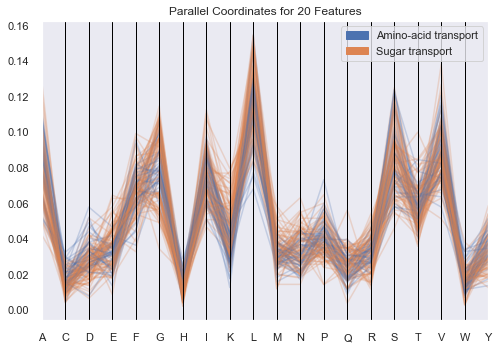

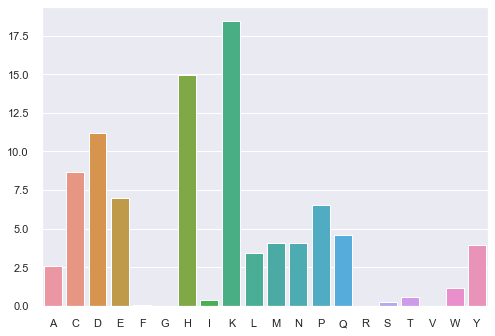

In [ ]:
pc = ParallelCoordinates()

pc.fit_transform(df_aac, df_labels.labels)
plt.savefig("plots/athaliana_sugar_amino_cluster70_aac_parallel_coordinates.png", dpi=300)
pc.show()

skb = SelectKBest(k=20)
skb.fit(df_aac, df_labels.labels)
sns.barplot(x=df_aac.columns, y=skb.scores_)
plt.savefig("plots/athaliana_sugar_amino_cluster70_aac_importance_anova.png", dpi=300)

### 3.6 Boxplots alle, amino, sugar

- Hier sieht man Unterschiede im Mittelwert bei den guten Features, allerdings auch Überschneidung
- Die guten Features zusammen könnten im 5-dimensionalen Raum für die guten SVM Ergebnisse sorgen.

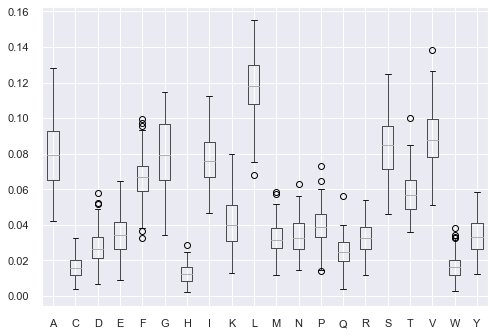

In [ ]:
df_aac.boxplot()
plt.savefig("plots/athaliana_sugar_amino_cluster70_aac_boxplot_all.png", dpi=300)

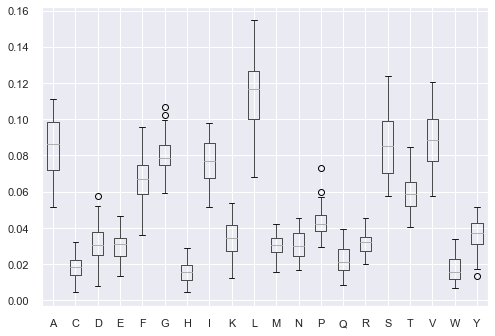

In [ ]:
df_aac.loc[mask_amino].boxplot()
plt.savefig("plots/athaliana_sugar_amino_cluster70_aac_boxplot_amino.png", dpi=300)

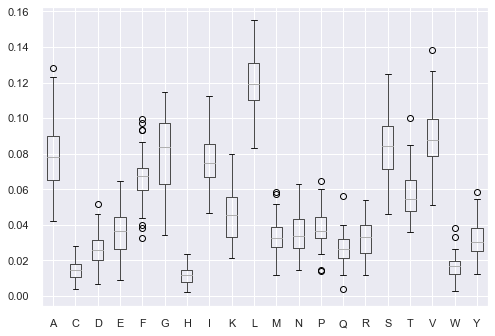

In [ ]:
df_aac.loc[mask_sugar].boxplot()
plt.savefig("plots/athaliana_sugar_amino_cluster70_aac_boxplot_sugar.png", dpi=300)

### PCA Plots

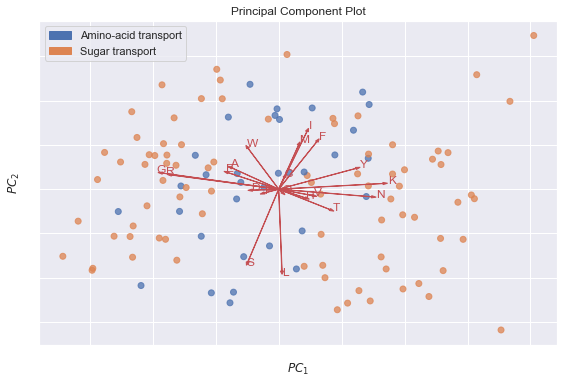

/home/ad/subpred/venv/lib/python3.8/site-packages/yellowbrick/features/pca.py:448: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self.fig.tight_layout()


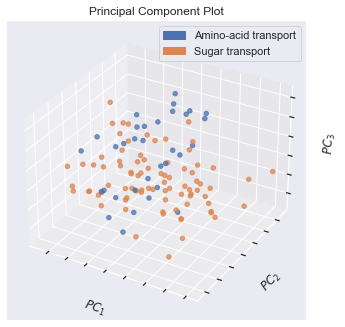

<Axes3DSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [ ]:
from yellowbrick.features import PCA as PCAPlot

df_aac = pd.read_table(
    f"../data/features/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}_aac.tsv",
    index_col=0,
)
df_labels = pd.read_table(
    f"../data/features/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}_labels.tsv",
    index_col=0,
)
le = LabelEncoder()
y = le.fit_transform(df_labels.labels.ravel())

pca_plot = PCAPlot(
    classes=le.classes_, scale=True, proj_features=True, features=df_aac.columns
)
pca_plot.fit_transform(df_aac.to_numpy(), y)
plt.savefig("plots/athaliana_sugar_amino_cluster70_aac_pca2.png", dpi=300)
pca_plot.show()

pca_plot = PCAPlot(
    classes=le.classes_,
    scale=True,
    features=df_aac.columns,
    projection=3,
)
pca_plot.fit_transform(df_aac.to_numpy(), y)
plt.savefig("plots/athaliana_sugar_amino_cluster70_aac_pca3.png", dpi=300)
pca_plot.show()


## Model training A Thaliana AAC, clustering 70, no outliers

In [13]:
df_aac = pd.read_table(
    f"../../data/features/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}_aac.tsv", index_col=0
)
df_labels = pd.read_table(
    f"../../data/features/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}_labels.tsv", index_col=0
)

X = df_aac.to_numpy()
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_labels.to_numpy().ravel())
nested_crossval(
    X, y, params={}, pipe=make_pipeline(StandardScaler(), GaussianNB()), scoring="f1_weighted"
)


,0,1,2,3,4,mean,std
test_score,0.758,0.713,0.865,0.873,0.867,0.815,0.074
train_score,0.946,0.925,0.895,0.915,0.902,0.917,0.020


## Relationship alpha helix membership model fit

In [244]:

df_aaindex = pd.read_csv("NAKH900111.csv")
col1 = pd.Series(
    data=df_aaindex.loc[0].tolist(),
    index=df_aaindex.columns.to_series().apply(lambda x: x[0]).tolist(),
)
col2 = pd.Series(
    data=df_aaindex.loc[0].tolist(),
    index=df_aaindex.columns.to_series().apply(lambda x: x[2]).tolist(),
)
aaindex = pd.concat([col1,col2]).sort_index()

df_plot = pd.DataFrame().assign(Helix_Propensity=aaindex)
df_plot.Helix_Propensity = minmax_scale(df_plot.Helix_Propensity)

In [245]:
kbest = SelectKBest(k=20)

labels = df_labels.labels
labels = np.where(labels == "Amino-acid transport", 0, 1)

kbest.fit(df_aac, labels)

feature_importances_kbest = pd.Series(index = kbest.feature_names_in_, data=kbest.scores_).sort_index()
# feature_importances_kbest = minmax_scale(feature_importances_kbest)
feature_importances_kbest = feature_importances_kbest / sum(feature_importances_kbest)

df_plot = df_plot.assign(
    ANOVA = feature_importances_kbest
)

In [246]:
from sklearn.preprocessing import minmax_scale


df_aac_sugar = df_aac.loc[df_labels[df_labels.labels == "Sugar transport"].index.tolist()]
df_aac_amino = df_aac.loc[df_labels[df_labels.labels == "Amino-acid transport"].index.tolist()]

df_aac_sugar_long = df_aac_sugar.melt(var_name="Amino acid", value_name="Normalized score").assign(Measure = "AA Frequency (Sugar)")
df_aac_amino_long = df_aac_amino.melt(var_name="Amino acid", value_name="Normalized score").assign(Measure = "AA Frequency (Amino-acid)")


In [247]:
df_plot = df_plot.sort_values("ANOVA", ascending=False).reset_index()
df_plot = df_plot.rename(columns = {"Helix_Propensity": "Helix propensity", "ANOVA": "Feature importance", "index": "Amino acid"})
df_plot

,Amino acid,Helix propensity,Feature importance
0,K,0.014228,0.200847
1,H,0.000000,0.162805
2,D,0.011179,0.121862
3,C,0.041667,0.094478
4,E,0.008130,0.076121
5,P,0.041667,0.070953
6,Q,0.050813,0.049672
7,M,0.029472,0.044584
8,N,0.029472,0.044337
9,Y,0.000000,0.043142


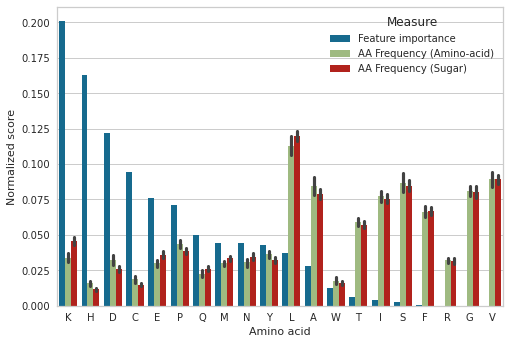

In [248]:
df_molten = df_plot.melt(id_vars=["Amino acid"], var_name="Measure", value_name="Normalized score")

df_molten = pd.concat([df_molten, df_aac_amino_long, df_aac_sugar_long])
sns.barplot(
    data=df_molten[df_molten.Measure != "Helix propensity"], x="Amino acid", y="Normalized score", hue="Measure"
)
plt.savefig("aac_feature_importance.png", dpi=300)